In [2]:
# Import libraries
import pandas as pd
import numpy  as np
import os
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time
from tensorflow import keras
from keras.metrics import SparseCategoricalAccuracy
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix
from keras import backend as K
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Add
from keras.models import load_model
import keras_tuner as kt

# from numpy.random import seed
# seed(1)
# tf.random.set_seed(2)

## Pre-processing data

In [3]:
# Merge sensor data with labels

labels = pd.read_csv("features_labels/labels_merged.csv") # Arousal and valence labels (binary)
audio_original = pd.read_csv("audio_features/AudioFeatures.csv")#.drop(columns=(["Accelerometer_Day","Accelerometer_Hour"]))
lexical_original = pd.read_csv("transcript/linguistic_features.csv")#.drop(columns=(["HR_Day","HR_Hour"]))


In [4]:
# Sometimes data is recorded for the other person since they are in close proximity. We want to remove these
fspeak = ["P_001","P_002","P_003","P_004","P_005","P_006","P_007","P_008","P_009","P_010","P_011","Z_012","P_013"]
mspeak = ["Z_001","Z_002","Z_003","Z_004","Z_005","Z_006","Z_007","Z_008","Z_009","Z_010","Z_011","P_012","Z_013"]
audio_original['ID'] = audio_original['Name'].str[:5]
audio_original_filter_final = audio_original.loc[(audio_original['ID'].isin(fspeak)) & (audio_original["Gender"] == "f") | (audio_original['ID'].isin(mspeak)) & (audio_original["Gender"] == "m")]

In [5]:
# Sometimes data is recorded for the other person since they are in close proximity. We want to remove these
# audio_original['ID'] = audio_original['Name'].str.split("_").str[:2].str.join("_")
# audio_original_filter = audio_original.drop(audio_original[(audio_original['Gender'] == "f") & (audio_original['ID'].str.startswith("P")) & (audio_original['ID'].str.startswith("P_012") != True)].index)
# audio_original_filter_final = audio_original_filter.drop(audio_original_filter[(audio_original_filter['Gender'] == "m") & (audio_original_filter['ID'].str.startswith("Z")) & (audio_original_filter['ID'].str.startswith("Z_012") != True)].index)
# audio_original_filter_final = audio_original_filter_final.reset_index(drop=True)

In [6]:
# audio_original_filter_final.to_csv("audio_filtered.csv", index=False)
# audio_original_filter_final.shape #299 samples, 285 after correct approach

In [7]:
# Sometimes data is recorded for the other person since they are in close proximity. We want to remove these
fspeak = ["P_001","P_002","P_003","P_004","P_005","P_006","P_007","P_008","P_009","P_010","P_011","Z_012","P_013"]
mspeak = ["Z_001","Z_002","Z_003","Z_004","Z_005","Z_006","Z_007","Z_008","Z_009","Z_010","Z_011","P_012","Z_013"]
lexical_original['ID'] = lexical_original['Name'].str[:5]
lexical_original_filter_final = lexical_original.loc[(lexical_original['ID'].isin(fspeak)) & (lexical_original["Gender"] == "f") | (lexical_original['ID'].isin(mspeak)) & (lexical_original["Gender"] == "m")]

In [8]:
# lexical_original['ID'] = lexical_original['Name'].str.split("_").str[:2].str.join("_")
# lexical_original_filter = lexical_original.drop(lexical_original[(lexical_original['Gender'] == "f") & (lexical_original['ID'].str.startswith("P")) & (lexical_original['ID'].str.startswith("P_012") != True)].index)
# lexical_original_filter_final = lexical_original_filter.drop(lexical_original_filter[((lexical_original_filter['Gender'] == "m") & (lexical_original_filter['ID'].str.startswith("Z"))) & ((lexical_original_filter['ID'].str.startswith("Z_012") != True))].index)
# lexical_original_filter_final = lexical_original_filter_final.reset_index(drop=True)

In [9]:
lexical_original_filter_final.shape 

(379, 771)

In [10]:
lexical_original_filter_final.drop(columns=(['Gender','ID']),inplace=True)
audio_original_filter_final.drop(columns=(['ID','Gender','Name Transcript']),inplace=True)

C:\Users\madha\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# Audio lexical merge

audio_lexical_merge = audio_original_filter_final.merge(lexical_original_filter_final, on="Name") 
audio_lexical_merge.shape

(357, 857)

In [13]:
audio_lexical_merge_arousal = audio_lexical_merge.merge(labels[["Name","Arousal_binary"]], on="Name")
audio_lexical_merge_valence = audio_lexical_merge.merge(labels[["Name","Valence_binary"]], on="Name")

In [14]:
audio_lexical_merge_arousal_groups = audio_lexical_merge_arousal['Name'].str.split("_").str[:2].str.join("")
audio_lexical_merge_valence_groups = audio_lexical_merge_valence['Name'].str.split("_").str[:2].str.join("")

In [15]:
audio_lexical_merge_arousal['Arousal_binary'].value_counts()

1    264
0     93
Name: Arousal_binary, dtype: int64

In [16]:
audio_lexical_merge_valence['Valence_binary'].value_counts()

1    337
0     20
Name: Valence_binary, dtype: int64

In [39]:
# Removing participants with 100% imbalance in arousal

audio_lexical_merge_arousal['PID'] = audio_lexical_merge_arousal['Name'].str[:5]
list_of_remove_participants_arousal = ['P_011','Z_001','Z_007','Z_008','Z_010','Z_011']
for pid in list_of_remove_participants_arousal:
    audio_lexical_merge_arousal = audio_lexical_merge_arousal[audio_lexical_merge_arousal.PID != pid]
    
# Define groups
audio_lexical_merge_arousal['ID'] = audio_lexical_merge_arousal['Name'].str[2:5]
audio_lexical_merge_arousal_groups = audio_lexical_merge_arousal['ID']#.reset_index(drop=True)

In [40]:
# Removing participants with 100% imbalance in valence

audio_lexical_merge_valence['PID'] = audio_lexical_merge_valence['Name'].str[:5]

list_of_remove_participants_valence = ['P_001','P_003','P_004','P_005','P_006','P_011','P_013','Z_001','Z_005','Z_007','Z_008', 'Z_010', 'Z_011', 'Z_012', 'Z_013']
for pid in list_of_remove_participants_valence:
    audio_lexical_merge_valence = audio_lexical_merge_valence[audio_lexical_merge_valence.PID != pid]
    
# Define groups
audio_lexical_merge_valence['ID'] = audio_lexical_merge_valence['Name'].str[2:5]
audio_lexical_merge_valence_groups = audio_lexical_merge_valence['ID']#.reset_index(drop=True)

In [41]:
# Shapes to check if merge done properly and samples left after removing participants in each emotion dimension

print(audio_original_filter_final.shape) # Samples coming from audio
print(lexical_original_filter_final.shape) # Samples coming from lexical (transcripts)
print(audio_lexical_merge.shape) # Samples after merging two modalities
print(audio_lexical_merge_arousal.shape) # Samples after removing participants with 100% class imbalance in arousal
print(audio_lexical_merge_valence.shape) # Samples after removing participants with 100% class imbalance in valence

(358, 89)
(379, 769)
(357, 857)
(274, 860)
(186, 860)


## Applying simple ML and DNN

### Early fusion: Arousal

In [43]:
# # Splitting in X and y and validation

# alA_x_all = audio_lexical_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
# alA_y_all = audio_lexical_merge_arousal["Arousal_binary"]

# # Get stratified split to make validation set
# cv = StratifiedGroupKFold(n_splits=4, random_state=5, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(alA_x_all, alA_y_all, audio_lexical_merge_arousal_groups)):
#     if folds == 1: 
#         alA_x = alA_x_all.iloc[train_idxs]
#         alA_y = alA_y_all.iloc[train_idxs]
#         alA_x_val = alA_x_all.iloc[test_idxs]
#         alA_y_val = alA_y_all.iloc[test_idxs]
        
#         train_test_groups_arousal = audio_lexical_merge_arousal_groups.iloc[train_idxs]
#         val_groups_arousal = audio_lexical_merge_arousal_groups.iloc[test_idxs]
        
#         train_test_groups_arousal_unique = np.unique(audio_lexical_merge_arousal_groups.iloc[train_idxs])
#         val_groups_arousal_unique = np.unique(audio_lexical_merge_arousal_groups.iloc[test_idxs])
        
# print(alA_x.shape)
# print(alA_x_val.shape)
# print("Train test groups: ", train_test_groups_arousal_unique)
# print("Validation groups: ", val_groups_arousal_unique)

In [42]:
# Splitting in X and y and validation

alA_x_all = audio_lexical_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
alA_y_all = audio_lexical_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = audio_lexical_merge_arousal.loc[~audio_lexical_merge_arousal['ID'].isin(["001", "006","010"])].index.to_list()
test_idxs = audio_lexical_merge_arousal.loc[audio_lexical_merge_arousal['ID'].isin(["001", "006","010"])].index

# Get stratified split to make validation set
alA_x = alA_x_all.loc[train_idxs]
alA_y = alA_y_all.loc[train_idxs]
alA_x_val = alA_x_all.loc[test_idxs]
alA_y_val = alA_y_all.loc[test_idxs]

train_test_groups_arousal = audio_lexical_merge_arousal_groups.loc[train_idxs]
val_groups_arousal = audio_lexical_merge_arousal_groups.loc[test_idxs]

train_test_groups_arousal_unique = np.unique(audio_lexical_merge_arousal_groups.loc[train_idxs])
val_groups_arousal_unique = np.unique(audio_lexical_merge_arousal_groups.loc[test_idxs])
        
print(alA_x.shape)
print(alA_x_val.shape)
print("Train test groups: ", train_test_groups_arousal_unique)
print("Validation groups: ", val_groups_arousal_unique)

(217, 856)
(57, 856)
Train test groups:  ['003' '004' '005' '007' '008' '009' '012' '013']
Validation groups:  ['001' '006' '010']


In [44]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(alA_x, alA_y, groups=train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.6135655976656949
Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'poly'}


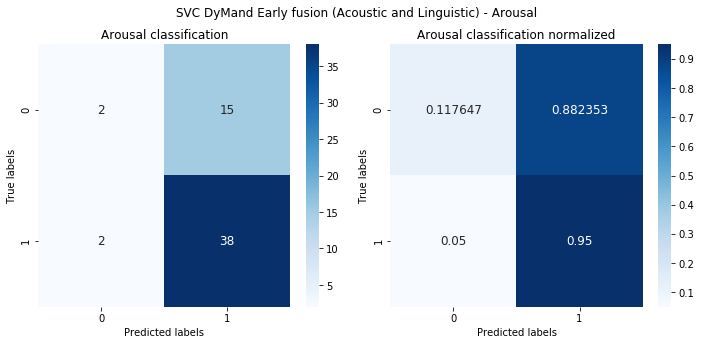

SVM validation Arousal score with best hyperparameters - Audio Lexical: 0.5338235294117647


In [325]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alA_x
y_train = alA_y
X_test = alA_x_val
y_test = alA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight="balanced", degree=2, kernel="poly")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Early fusion (Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Audio Lexical:", uar)

In [76]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=28, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(alA_x, alA_y, train_test_groups_arousal)):
    if folds == 1: 
        alA_x_train = alA_x_all.iloc[train_idxs]
        alA_y_train = alA_y_all.iloc[train_idxs]
        alA_x_test = alA_x_all.iloc[test_idxs]
        alA_y_test = alA_y_all.iloc[test_idxs]
        
        alA_x_train_groups = np.unique(train_test_groups_arousal.iloc[train_idxs])
        alA_x_test_groups = np.unique(train_test_groups_arousal.iloc[test_idxs])
        
print("Training groups: ", alA_x_train_groups)
print("Testing groups: ", alA_x_test_groups)

Training groups:  ['003' '004' '005' '009' '012' '013']
Testing groups:  ['007' '008']


In [77]:
# Defining UAR metric

def UAR_metric(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    uar = ((tp / (tp+fn+K.epsilon())) + (tn /(tn+fp+K.epsilon()))) /2
    return uar

In [78]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=856, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_AudioLexicalMerge',
                     project_name='Trial8Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(alA_x_train, alA_y_train, epochs=100, validation_data=(alA_x_test, alA_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5314815044403076

Best val_UAR_metric So Far: 0.7324074506759644
Total elapsed time: 00h 02m 04s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 240 
 Second layer: 288 
 Third layer: 464 
 
 Dropout 1: 0.4 
 Dropout 2: 0.0 
 Dropout 3: 0.0 
 and the optimal learning rate for the optimizer
is 0.001.



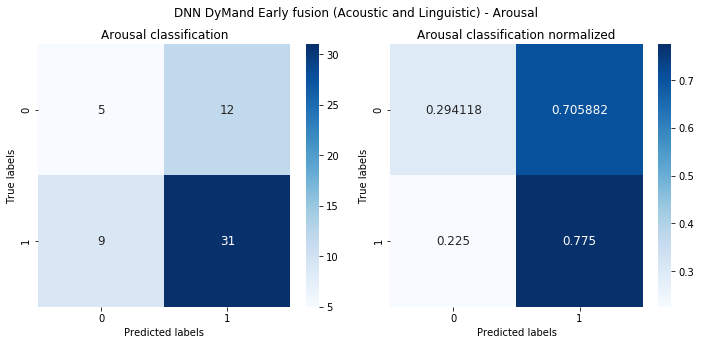

DNN validation score arousal with best hyperparameters -- Audio Lexical 0.5345588235294118


In [307]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alA_x
y_train = alA_y
X_test = alA_x_val
y_test = alA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
model = Sequential()
model.add(Dense(240, input_dim=856, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(228, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(464, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(448, input_dim=856, activation="relu"))
#     model.add(Dropout(0.2))
#     model.add(Dense(96, activation="relu"))
#     model.add(Dropout(0.2))
#     model.add(Dense(192, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=1e-05)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Early fusion (Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Audio Lexical", uar)
# print("DNN validation score arousal with best hyperparameters -- Audio Lexical", np.mean(uar_average), np.std(uar_average))

In [83]:
## Transfer learning 

audio_lexical_merge_TL_model_arousal = load_model("../VAM/VAM_audio_lexical_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.0001

# StandardScaler
audio_lexical_merge_scaler = StandardScaler()
alA_x_scaled = audio_lexical_merge_scaler.fit_transform(alA_x)
alA_x_scaled_val = audio_lexical_merge_scaler.transform(alA_x_val)

#Freezing no layers
opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_arousal.summary()
audio_lexical_merge_TL_model_arousal.fit(alA_x_scaled, alA_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_arousal.predict(alA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alA_y_val, y_pred)
print("Transfer learning after freezing 0 layers", np.round(uar,3))


# Freezing layers first layer (including dropout)
audio_lexical_merge_TL_model_arousal = load_model("../VAM/VAM_audio_lexical_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    audio_lexical_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_arousal.summary()
audio_lexical_merge_TL_model_arousal.fit(alA_x_scaled, alA_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_arousal.predict(alA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alA_y_val, y_pred)
print("Transfer learning after freezing 1 layer", np.round(uar,3))


# Freezing layers first 2 layers (including dropout)
audio_lexical_merge_TL_model_arousal = load_model("../VAM/VAM_audio_lexical_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    audio_lexical_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_arousal.summary()
audio_lexical_merge_TL_model_arousal.fit(alA_x_scaled, alA_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_arousal.predict(alA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alA_y_val, y_pred)
print("Transfer learning after freezing 2 layers", np.round(uar,3))


# Freezing layers first 3 layers (including dropout)
audio_lexical_merge_TL_model_arousal = load_model("../VAM/VAM_audio_lexical_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    audio_lexical_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_arousal.summary()
audio_lexical_merge_TL_model_arousal.fit(alA_x_scaled, alA_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_arousal.predict(alA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alA_y_val, y_pred)
print("Transfer learning after freezing 3 layers", np.round(uar,3))


# Freezing layers first 4 layers (including dropout)
audio_lexical_merge_TL_model_arousal = load_model("../VAM/VAM_audio_lexical_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    audio_lexical_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_arousal.summary()
audio_lexical_merge_TL_model_arousal.fit(alA_x_scaled, alA_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_arousal.predict(alA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alA_y_val, y_pred)
print("Transfer learning after freezing 4 layers", np.round(uar,3))

Transfer learning after freezing 0 layers 0.568
Transfer learning after freezing 1 layer 0.522
Transfer learning after freezing 2 layers 0.576
Transfer learning after freezing 3 layers 0.551
Transfer learning after freezing 4 layers 0.543


Transfer learning after freezing 2 layers 0.551


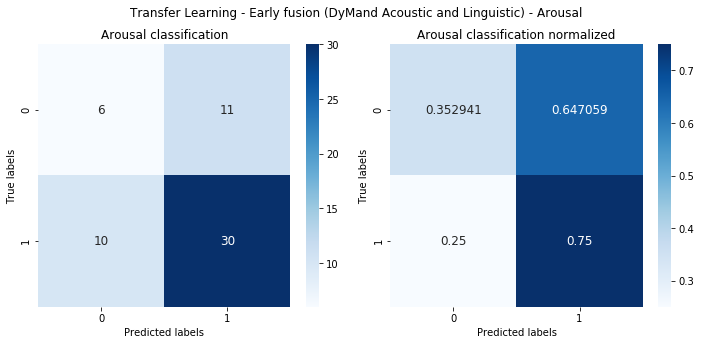

In [306]:
# Freezing layers first 2 layers (including dropout)
audio_lexical_merge_TL_model_arousal = load_model("../VAM/VAM_audio_lexical_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    audio_lexical_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_arousal.summary()
audio_lexical_merge_TL_model_arousal.fit(alA_x_scaled, alA_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_arousal.predict(alA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alA_y_val, y_pred)
print("Transfer learning after freezing 2 layers", np.round(uar,3))

# Plotting the confusion matrix
cm = confusion_matrix(alA_y_val,y_pred)
cm_normalized = confusion_matrix(alA_y_val,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Early fusion (DyMand Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Early fusion: Valence


In [ ]:
# Splitting in X and y old
# alV_x = audio_lexical_merge_valence.drop(columns=(["Name","Valence_binary"]))
# alV_y = audio_lexical_merge_valence["Valence_binary"]

In [117]:
# Splitting in X and y and validation

alV_x_all = audio_lexical_merge_valence.drop(columns=(["Name","Valence_binary","PID","ID"]))
alV_y_all = audio_lexical_merge_valence["Valence_binary"]

# Get stratified split to make validation set
cv = StratifiedGroupKFold(n_splits=5, random_state=29, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(alV_x_all, alV_y_all, audio_lexical_merge_valence_groups)):
    if folds == 1: 
        alV_x = alV_x_all.iloc[train_idxs]
        alV_y = alV_y_all.iloc[train_idxs]
        alV_x_val = alV_x_all.iloc[test_idxs]
        alV_y_val = alV_y_all.iloc[test_idxs]
        
        train_test_groups_valence = audio_lexical_merge_valence_groups.iloc[train_idxs]
        val_groups_valence = audio_lexical_merge_valence_groups.iloc[test_idxs]
        
        train_test_groups_valence_unique = np.unique(audio_lexical_merge_valence_groups.iloc[train_idxs])
        val_groups_valence_unique = np.unique(audio_lexical_merge_valence_groups.iloc[test_idxs])
        
print(alV_x.shape)
print(alV_x_val.shape)
print("Train test groups: ", train_test_groups_valence_unique)
print("Validation groups: ", val_groups_valence_unique)

(126, 856)
(60, 856)
Train test groups:  ['003' '006' '007' '008' '010' '012']
Validation groups:  ['004' '009']


In [ ]:
# uar_average = []

# cv = StratifiedGroupKFold(n_splits=4, random_state=12, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(alV_x, alV_y, train_test_groups_valence)):
    
#     X_train = alV_x.iloc[train_idxs]
#     y_train = alV_y.iloc[train_idxs]
#     X_test = alV_x.iloc[test_idxs]
#     y_test = alV_y.iloc[test_idxs]

#     # StandardScaler
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Fitting SVM training
#     svm = SVC()
#     svm.fit(X_train_scaled, y_train),
#     y_pred = svm.predict(X_test_scaled)

#     uar = balanced_accuracy_score(y_test,y_pred)
#     uar_average.append(uar)

# print("SVM test score avg valence (5 folds) -- Audio Lexical", np.mean(uar_average), "(std: "+str(np.std(uar_average))+")")

In [118]:
# Hyperparameter tuning

start_time = time.time()
# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=4, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(alV_x, alV_y, groups=train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

end_time = time.time()
print("Time taken: ", end_time - start_time)

Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best Score: 0.575925925925926
Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'sigmoid'}
Time taken:  7.1597654819488525


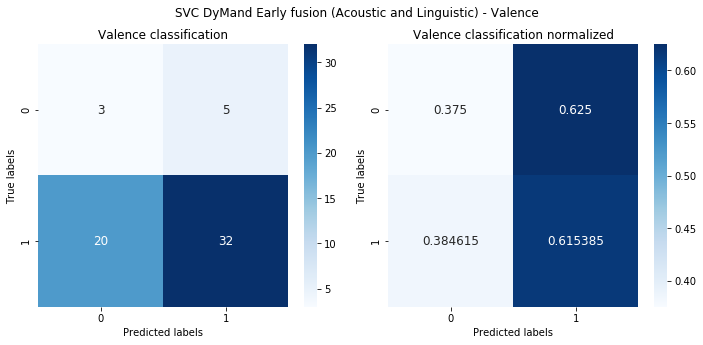

SVM validation score valence with best hyperparameters -- Audio Lexical: 0.4951923076923077


In [326]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alV_x
y_train = alV_y
X_test = alV_x_val
y_test = alV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight="balanced", degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)
uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Early fusion (Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation score valence with best hyperparameters -- Audio Lexical:", uar)

In [ ]:
# ## Deep learning

# def UAR_metric(y_true, y_pred):
#     tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
#     fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
#     fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
#     uar = ((tp / (tp+fn+K.epsilon())) + (tn /(tn+fp+K.epsilon()))) /2
#     return uar

# uar_average = []
# cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(alV_x, alV_y, train_test_groups_valence)):
    
#     #if folds == 1:
    
#     X_train = alV_x.iloc[train_idxs]
#     y_train = alV_y.iloc[train_idxs]
#     X_test = alV_x.iloc[test_idxs]
#     y_test = alV_y.iloc[test_idxs]

#     # StandardScaler
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Fitting DNN
#     model = Sequential()
#     model.add(Dense(200, input_dim=856, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(100, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     uar_average.append(uar)
    
# print("DNN test score avg valence (5 folds)", np.mean(uar_average), "(std: "+str(np.std(uar_average))+")")

In [129]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=4, random_state=8, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(alV_x, alV_y, train_test_groups_valence)):
    if folds == 1: 
        alV_x_train = alV_x_all.iloc[train_idxs]
        alV_y_train = alV_y_all.iloc[train_idxs]
        alV_x_test = alV_x_all.iloc[test_idxs]
        alV_y_test = alV_y_all.iloc[test_idxs]
        
        alV_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        alV_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", alV_x_train_groups)
print("Testing groups: ", alV_x_test_groups)

Training groups:  ['003' '006' '007' '008' '012']
Testing groups:  ['010']


In [130]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=856, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_AudioLexicalMerge',
                     project_name='Trial5Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(alV_x_train, alV_y_train, epochs=100, validation_data=(alV_x_test, alV_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5263158082962036

Best val_UAR_metric So Far: 0.8947368860244751
Total elapsed time: 00h 02m 28s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 464 
 Second layer: 288 
 Third layer: 416 
 
 Dropout 1: 0.1 
 Dropout 2: 0.0 
 Dropout 3: 0.1 
 and the optimal learning rate for the optimizer
is 0.0001.



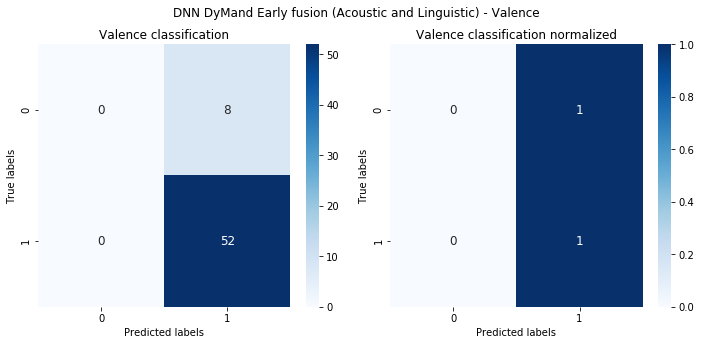

DNN validation score with best hyperparameters for valence: 0.5


In [328]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alV_x
y_train = alV_y
X_test = alV_x_val
y_test = alV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(464, input_dim=856, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(228, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(416, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=10)
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(224, input_dim=856, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(160, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(384, activation="relu"))
#     model.add(Dropout(0.4))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=1e-5)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     # stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=10)
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Early fusion (Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("DNN validation score with best hyperparameters for valence:", uar)

In [313]:
## Transfer learning 

audio_lexical_merge_TL_model_valence = load_model("../VAM/VAM_audio_lexical_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 1e-5

# StandardScaler
audio_lexical_merge_scaler = StandardScaler()
alV_x_scaled = audio_lexical_merge_scaler.fit_transform(alV_x)
alV_x_scaled_val = audio_lexical_merge_scaler.transform(alV_x_val)

#Freezing no layers
# for i in range(7):
#     audio_lexical_merge_TL_model_valence.layers[i].trainable = True

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_valence.summary()
audio_lexical_merge_TL_model_valence.fit(alV_x_scaled, alV_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_valence.predict(alV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alV_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
audio_lexical_merge_TL_model_valence = load_model("../VAM/VAM_audio_lexical_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    audio_lexical_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_valence.summary()
audio_lexical_merge_TL_model_valence.fit(alV_x_scaled, alV_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_valence.predict(alV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alV_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
audio_lexical_merge_TL_model_valence = load_model("../VAM/VAM_audio_lexical_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    audio_lexical_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_valence.summary()
audio_lexical_merge_TL_model_valence.fit(alV_x_scaled, alV_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_valence.predict(alV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alV_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
audio_lexical_merge_TL_model_valence = load_model("../VAM/VAM_audio_lexical_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    audio_lexical_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_valence.summary()
audio_lexical_merge_TL_model_valence.fit(alV_x_scaled, alV_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_valence.predict(alV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alV_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
audio_lexical_merge_TL_model_valence = load_model("../VAM/VAM_audio_lexical_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    audio_lexical_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_valence.summary()
audio_lexical_merge_TL_model_valence.fit(alV_x_scaled, alV_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_valence.predict(alV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alV_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

Transfer learning after freezing 0 layers 0.5961538461538461
Transfer learning after freezing 1 layer 0.5769230769230769
Transfer learning after freezing 2 layers 0.5
Transfer learning after freezing 3 layers 0.5
Transfer learning after freezing 4 layers 0.5


Transfer learning after freezing 1 layer 0.5769230769230769


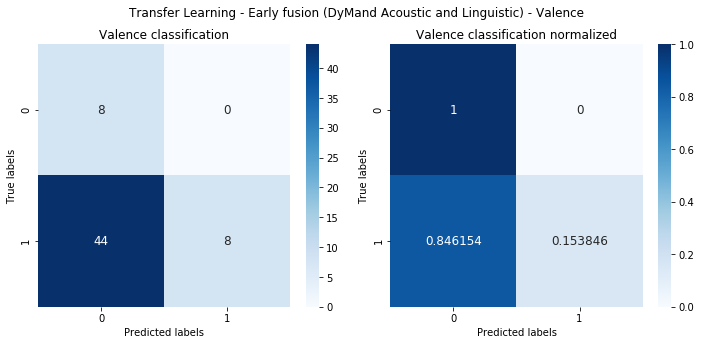

In [314]:
# Freezing layers first layer (including dropout)
audio_lexical_merge_TL_model_valence = load_model("../VAM/VAM_audio_lexical_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    audio_lexical_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_lexical_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_lexical_merge_TL_model_valence.summary()
audio_lexical_merge_TL_model_valence.fit(alV_x_scaled, alV_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_lexical_merge_TL_model_valence.predict(alV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(alV_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)

# Plotting the confusion matrix
cm = confusion_matrix(alV_y_val,y_pred)
cm_normalized = confusion_matrix(alV_y_val,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Early fusion (DyMand Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Late Fusion pre-processing

In [133]:
#### Keeping the inputs different ############

# audio_unimodal_features = audio_original_filter_final.copy()
# lexical_unimodal_features = lexical_original_filter_final.copy()

# audio_unimodal_labels_merge_arousal = audio_unimodal_features.merge(labels[["Name","Arousal_binary"]], on="Name")
# lexical_unimodal_labels_merge_arousal = lexical_unimodal_features.merge(labels[["Name","Arousal_binary"]], on="Name")

# audio_unimodal_labels_merge_valence = audio_unimodal_features.merge(labels[["Name","Valence_binary"]], on="Name")
# lexical_unimodal_labels_merge_valence = lexical_unimodal_features.merge(labels[["Name","Valence_binary"]], on="Name")

In [218]:
# ###### Matching inputs to be same for audio and lexical - because of late fusion ############

audio_unimodal_features_original = audio_original_filter_final.copy()
lexical_unimodal_features_original = lexical_original_filter_final.copy()

audio_features_name = audio_unimodal_features_original.columns.to_list()
lexical_features_name = lexical_unimodal_features_original.columns.to_list()

audio_lexical_unimodal_merge = audio_unimodal_features_original.merge(lexical_unimodal_features_original, on="Name")

audio_unimodal_features = audio_lexical_unimodal_merge[audio_features_name]
lexical_unimodal_features = audio_lexical_unimodal_merge[lexical_features_name]

audio_unimodal_labels_merge_arousal = audio_unimodal_features.merge(labels[["Name","Arousal_binary"]], on="Name")
lexical_unimodal_labels_merge_arousal = lexical_unimodal_features.merge(labels[["Name","Arousal_binary"]], on="Name")

audio_unimodal_labels_merge_valence = audio_unimodal_features.merge(labels[["Name","Valence_binary"]], on="Name")
lexical_unimodal_labels_merge_valence = lexical_unimodal_features.merge(labels[["Name","Valence_binary"]], on="Name")


In [219]:
audio_arousal_groups = audio_unimodal_labels_merge_arousal['Name'].str.split("_").str[:2].str.join("")
audio_valence_groups = audio_unimodal_labels_merge_valence['Name'].str.split("_").str[:2].str.join("")

lexical_arousal_groups = lexical_unimodal_labels_merge_arousal['Name'].str.split("_").str[:2].str.join("")
lexical_valence_groups = lexical_unimodal_labels_merge_valence['Name'].str.split("_").str[:2].str.join("")

In [220]:
print(audio_unimodal_labels_merge_arousal.shape)
print(lexical_unimodal_labels_merge_arousal.shape)
print(audio_unimodal_labels_merge_valence.shape)
print(lexical_unimodal_labels_merge_valence.shape)

(357, 90)
(357, 770)
(357, 90)
(357, 770)


In [221]:
# Removing participants with 100% imbalance in arousal

# Audio arousal
audio_unimodal_labels_merge_arousal['PID'] = audio_unimodal_labels_merge_arousal['Name'].str[:5]
list_of_remove_participants_arousal = ['P_011','Z_001','Z_007','Z_008','Z_010','Z_011']
for pid in list_of_remove_participants_arousal:
    audio_unimodal_labels_merge_arousal = audio_unimodal_labels_merge_arousal[audio_unimodal_labels_merge_arousal.PID != pid]
# Define groups    
#audio_arousal_groups = audio_unimodal_labels_merge_arousal['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)

# Define groups
audio_unimodal_labels_merge_arousal['ID'] = audio_unimodal_labels_merge_arousal['Name'].str[2:5]
audio_arousal_groups = audio_unimodal_labels_merge_arousal['ID']#.reset_index(drop=True)


# Lexical arousal
lexical_unimodal_labels_merge_arousal['PID'] = lexical_unimodal_labels_merge_arousal['Name'].str[:5]
list_of_remove_participants_arousal = ['P_011','Z_001','Z_007','Z_008','Z_010','Z_011']
for pid in list_of_remove_participants_arousal:
    lexical_unimodal_labels_merge_arousal = lexical_unimodal_labels_merge_arousal[lexical_unimodal_labels_merge_arousal.PID != pid]
# Define groups    
# lexical_arousal_groups = lexical_unimodal_labels_merge_arousal['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)
# Define groups
lexical_unimodal_labels_merge_arousal['ID'] = lexical_unimodal_labels_merge_arousal['Name'].str[2:5]
lexical_arousal_groups = lexical_unimodal_labels_merge_arousal['ID']#.reset_index(drop=True)

In [222]:
# Removing participants with 100% imbalance in valence

# Audio valence
audio_unimodal_labels_merge_valence['PID'] = audio_unimodal_labels_merge_valence['Name'].str[:5]
list_of_remove_participants_valence = ['P_001','P_003','P_004','P_005','P_006','P_011','P_013','Z_001','Z_005','Z_007','Z_008', 'Z_010', 'Z_011', 'Z_012', 'Z_013']
for pid in list_of_remove_participants_valence:
    audio_unimodal_labels_merge_valence = audio_unimodal_labels_merge_valence[audio_unimodal_labels_merge_valence.PID != pid]
# Define groups    
# audio_valence_groups = audio_unimodal_labels_merge_valence['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)
# Define groups
audio_unimodal_labels_merge_valence['ID'] = audio_unimodal_labels_merge_valence['Name'].str[2:5]
audio_valence_groups = audio_unimodal_labels_merge_valence['ID']#.reset_index(drop=True)


# Lexical valence
lexical_unimodal_labels_merge_valence['PID'] = lexical_unimodal_labels_merge_valence['Name'].str[:5]
list_of_remove_participants_valence = ['P_001','P_003','P_004','P_005','P_006','P_011','P_013','Z_001','Z_005','Z_007','Z_008', 'Z_010', 'Z_011', 'Z_012', 'Z_013']
for pid in list_of_remove_participants_valence:
    lexical_unimodal_labels_merge_valence = lexical_unimodal_labels_merge_valence[lexical_unimodal_labels_merge_valence.PID != pid]
# Define groups    
# lexical_valence_groups = lexical_unimodal_labels_merge_valence['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)
# Define groups
lexical_unimodal_labels_merge_valence['ID'] = lexical_unimodal_labels_merge_valence['Name'].str[2:5]
lexical_valence_groups = lexical_unimodal_labels_merge_valence['ID']#.reset_index(drop=True)

In [223]:
# Checking if correct number of samples are there are removal

print(audio_unimodal_labels_merge_arousal.shape)
print(lexical_unimodal_labels_merge_arousal.shape)
print(audio_unimodal_labels_merge_valence.shape)
print(lexical_unimodal_labels_merge_valence.shape)

(274, 92)
(274, 772)
(186, 92)
(186, 772)


### Late Fusion: Arousal -- Audio

In [144]:
# # Splitting in X and y old
# # audio_arousal_x = audio_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary"]))
# # audio_arousal_y = audio_unimodal_labels_merge_arousal["Arousal_binary"]

# audio_arousal_x_all = audio_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
# audio_arousal_y_all = audio_unimodal_labels_merge_arousal["Arousal_binary"]

# # Get stratified split to make validation set
# cv = StratifiedGroupKFold(n_splits=5, random_state=1, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(audio_arousal_x_all, audio_arousal_y_all, audio_arousal_groups)):
#     if folds == 1: 
#         audio_arousal_x = audio_arousal_x_all.iloc[train_idxs]
#         audio_arousal_y = audio_arousal_y_all.iloc[train_idxs]
#         audio_arousal_x_val = audio_arousal_x_all.iloc[test_idxs]
#         audio_arousal_y_val = audio_arousal_y_all.iloc[test_idxs]
        
#         audio_train_test_groups_arousal = audio_arousal_groups.iloc[train_idxs]
#         audio_val_groups_arousal = audio_arousal_groups.iloc[test_idxs]
        
#         audio_train_test_groups_arousal_unique = np.unique(audio_arousal_groups.iloc[train_idxs])
#         audio_val_groups_arousal_unique = np.unique(audio_arousal_groups.iloc[test_idxs])
        
# print(audio_arousal_x.shape)
# print(audio_arousal_x_val.shape)
# print("Train test groups: ", audio_train_test_groups_arousal_unique)
# print("Validation groups: ", audio_val_groups_arousal_unique)


In [224]:
audio_arousal_x_all = audio_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
audio_arousal_y_all = audio_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = audio_unimodal_labels_merge_arousal.loc[~audio_unimodal_labels_merge_arousal['ID'].isin(["001", "006","010"])].index.to_list()
test_idxs = audio_unimodal_labels_merge_arousal.loc[audio_unimodal_labels_merge_arousal['ID'].isin(["001", "006","010"])].index

audio_arousal_x = audio_arousal_x_all.loc[train_idxs]
audio_arousal_y = audio_arousal_y_all.loc[train_idxs]
audio_arousal_x_val = audio_arousal_x_all.loc[test_idxs]
audio_arousal_y_val = audio_arousal_y_all.loc[test_idxs]

audio_train_test_groups_arousal = audio_arousal_groups.loc[train_idxs]
audio_val_groups_arousal = audio_arousal_groups.loc[test_idxs]

audio_train_test_groups_arousal_unique = np.unique(audio_arousal_groups.loc[train_idxs])
audio_val_groups_arousal_unique = np.unique(audio_arousal_groups.loc[test_idxs])
        
print(audio_arousal_x.shape)
print(audio_arousal_x_val.shape)
print("Train test groups: ", audio_train_test_groups_arousal_unique)
print("Validation groups: ", audio_val_groups_arousal_unique)

(217, 88)
(57, 88)
Train test groups:  ['003' '004' '005' '007' '008' '009' '012' '013']
Validation groups:  ['001' '006' '010']


In [146]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(audio_arousal_x, audio_arousal_y, groups=audio_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.6015634410162815
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'rbf'}


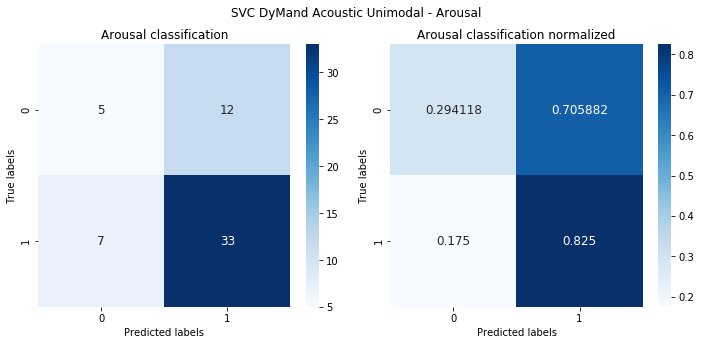

SVM validation Arousal score with best hyperparameters - Audio Model: 0.5595588235294118


In [315]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_arousal_x
y_train = audio_arousal_y
X_test = audio_arousal_x_val
y_test = audio_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight="balanced", degree=2, kernel="rbf")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Acoustic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Audio Model:", uar)

In [226]:
## Deep learning

def UAR_metric(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    uar = ((tp / (tp+fn+K.epsilon())) + (tn /(tn+fp+K.epsilon()))) /2
    return uar

In [227]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=28, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(audio_arousal_x, audio_arousal_y, audio_train_test_groups_arousal)):
    if folds == 1: 
        audio_arousal_x_train = audio_arousal_x_all.iloc[train_idxs]
        audio_arousal_y_train = audio_arousal_y_all.iloc[train_idxs]
        audio_arousal_x_test = audio_arousal_x_all.iloc[test_idxs]
        audio_arousal_y_test = audio_arousal_y_all.iloc[test_idxs]
        
        audio_arousal_x_train_groups = np.unique(audio_train_test_groups_arousal.iloc[train_idxs])
        audio_arousal_x_test_groups = np.unique(audio_train_test_groups_arousal.iloc[test_idxs])
        
print("Training groups: ", audio_arousal_x_train_groups)
print("Testing groups: ", audio_arousal_x_test_groups)

Training groups:  ['003' '004' '005' '009' '012' '013']
Testing groups:  ['007' '008']


In [152]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=88, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_AudioLexicalUnimodal',
                     project_name='Trial4_Audio_Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(audio_arousal_x_train, audio_arousal_y_train, epochs=100, validation_data=(audio_arousal_x_test, audio_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.7186965942382812
Total elapsed time: 00h 02m 05s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 160 
 Second layer: 80 
 Third layer: 400 
 
 Dropout 1: 0.3 
 Dropout 2: 0.0 
 Dropout 3: 0.2 
 and the optimal learning rate for the optimizer
is 0.001.



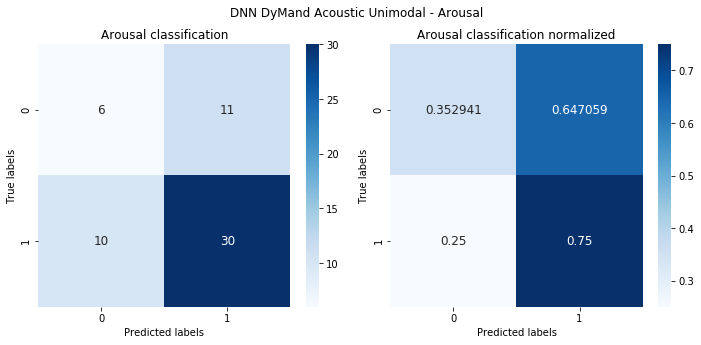

DNN validation score arousal with best hyperparameters -- Audio Lexical 0.5514705882352942


In [317]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_arousal_x
y_train = audio_arousal_y
X_test = audio_arousal_x_val
y_test = audio_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(160, input_dim=88, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(400, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# ############# Remove #####################
# # Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(496, input_dim=88, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(336, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(224, activation="relu"))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
# ############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Acoustic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Audio", uar)
# print("DNN validation score arousal with best hyperparameters -- Audio Model", np.mean(uar_average), np.std(uar_average))

### Late Fusion: Valence -- Audio

In [157]:
audio_valence_x_all = audio_unimodal_labels_merge_valence.drop(columns=(["Name","Valence_binary","PID", "ID"]))
audio_valence_y_all = audio_unimodal_labels_merge_valence["Valence_binary"]

# Get stratified split to make validation set
cv = StratifiedGroupKFold(n_splits=5, random_state=29, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(audio_valence_x_all, audio_valence_y_all, audio_valence_groups)):
    if folds == 1: 
        audio_valence_x = audio_valence_x_all.iloc[train_idxs]
        audio_valence_y = audio_valence_y_all.iloc[train_idxs]
        audio_valence_x_val = audio_valence_x_all.iloc[test_idxs]
        audio_valence_y_val = audio_valence_y_all.iloc[test_idxs]
        
        audio_train_test_groups_valence = audio_valence_groups.iloc[train_idxs]
        audio_val_groups_valence = audio_valence_groups.iloc[test_idxs]
        
        audio_train_test_groups_valence_unique = np.unique(audio_valence_groups.iloc[train_idxs])
        audio_val_groups_valence_unique = np.unique(audio_valence_groups.iloc[test_idxs])
        
print(audio_valence_x.shape)
print(audio_valence_x_val.shape)
print("Train test groups: ", audio_train_test_groups_valence_unique)
print("Validation groups: ", audio_val_groups_valence_unique)

(126, 88)
(60, 88)
Train test groups:  ['003' '006' '007' '008' '010' '012']
Validation groups:  ['004' '009']


In [ ]:
# Hyperparameter tuning SVM

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=4, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(audio_valence_x, audio_valence_y, groups=audio_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


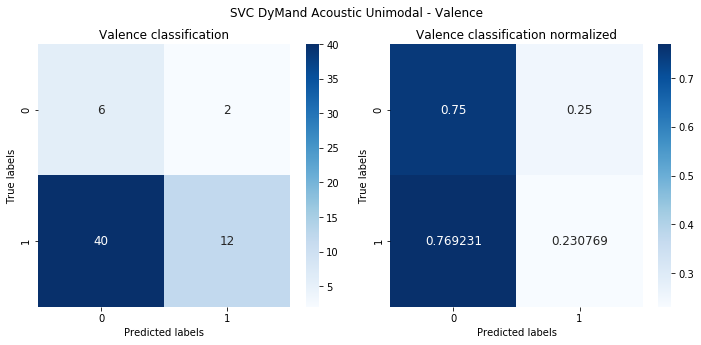

SVM validation score valence with best hyperparameters -- Audio Unimodal: 0.4903846153846154


In [318]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_valence_x
y_train = audio_valence_y
X_test = audio_valence_x_val
y_test = audio_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight="balanced", degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)
uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Acoustic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation score valence with best hyperparameters -- Audio Unimodal:", uar)

In [158]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=4, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(audio_valence_x, audio_valence_y, audio_train_test_groups_valence)):
    if folds == 1: 
        audio_valence_x_train = audio_valence_x_all.iloc[train_idxs]
        audio_valence_y_train = audio_valence_y_all.iloc[train_idxs]
        audio_valence_x_test = audio_valence_x_all.iloc[test_idxs]
        audio_valence_y_test = audio_valence_y_all.iloc[test_idxs]
        
        audio_valence_x_train_groups_numbers = audio_train_test_groups_valence.iloc[train_idxs]
        audio_valence_x_test_groups_numbers = audio_train_test_groups_valence.iloc[test_idxs]
        
        audio_valence_x_train_groups = np.unique(audio_train_test_groups_valence.iloc[train_idxs])
        audio_valence_x_test_groups = np.unique(audio_train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", audio_valence_x_train_groups)
print("Testing groups: ", audio_valence_x_test_groups)
# print("Training size", audio_valence_x_train_groups_numbers.shape)
# print("Testing size", audio_valence_x_test_groups_numbers.shape)

Training groups:  ['003' '007' '008' '010' '012']
Testing groups:  ['006']


In [159]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=88, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_AudioLexicalUnimodal',
                     project_name='Trial5_Audio_Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(audio_valence_x_train, audio_valence_y_train, epochs=100, validation_data=(audio_valence_x_test, audio_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.9999999403953552
Total elapsed time: 00h 02m 08s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 128 
 Second layer: 304 
 Third layer: 240 
 
 Dropout 1: 0.2 
 Dropout 2: 0.1 
 Dropout 3: 0.5 
 and the optimal learning rate for the optimizer
is 1e-05.



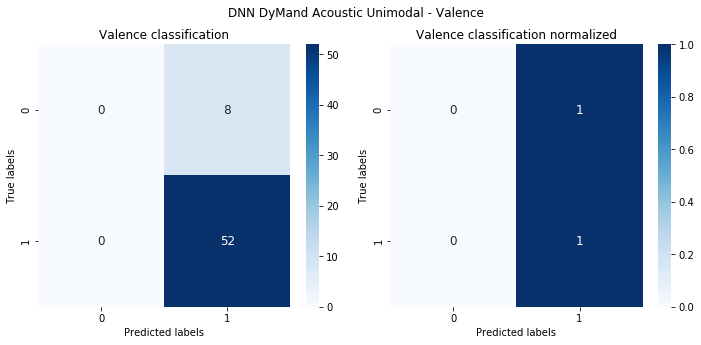

DNN validation score valence with best hyperparameters -- Audio Lexical 0.5


In [319]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_valence_x
y_train = audio_valence_y
X_test = audio_valence_x_val
y_test = audio_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(128, input_dim=88, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(304, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(240, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# # Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(464, input_dim=88, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(304, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(32, activation="relu"))
#     model.add(Dropout(0.0))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Acoustic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score valence with best hyperparameters -- Audio Lexical", uar)
# print("DNN validation score valence with best hyperparameters -- Audio Model", np.mean(uar_average), np.std(uar_average))

### Late Fusion: Arousal -- Lexical 

In [228]:
#### Splitting in X and y old
# lexical_arousal_x = lexical_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary"]))
# lexical_arousal_y = lexical_unimodal_labels_merge_arousal["Arousal_binary"]

lexical_arousal_x_all = lexical_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
lexical_arousal_y_all = lexical_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal
train_idxs = lexical_unimodal_labels_merge_arousal.loc[~lexical_unimodal_labels_merge_arousal['ID'].isin(["001", "006","010"])].index.to_list()
test_idxs = lexical_unimodal_labels_merge_arousal.loc[lexical_unimodal_labels_merge_arousal['ID'].isin(["001", "006","010"])].index

# Get stratified split to make validation set (same groups as before)

lexical_arousal_x = lexical_arousal_x_all.loc[train_idxs]
lexical_arousal_y = lexical_arousal_y_all.loc[train_idxs]
lexical_arousal_x_val = lexical_arousal_x_all.loc[test_idxs]
lexical_arousal_y_val = lexical_arousal_y_all.loc[test_idxs]

lexical_train_test_groups_arousal = lexical_arousal_groups.loc[train_idxs]
lexical_val_groups_arousal = lexical_arousal_groups.loc[test_idxs]

lexical_train_test_groups_arousal_unique = np.unique(lexical_arousal_groups.loc[train_idxs])
lexical_val_groups_arousal_unique = np.unique(lexical_arousal_groups.loc[test_idxs])
        
print(lexical_arousal_x.shape)
print(lexical_arousal_x_val.shape)
print("Train test groups: ", lexical_train_test_groups_arousal_unique)
print("Validation groups: ", lexical_val_groups_arousal_unique) # Don't have any negative valence!

(217, 768)
(57, 768)
Train test groups:  ['003' '004' '005' '007' '008' '009' '012' '013']
Validation groups:  ['001' '006' '010']


In [ ]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(lexical_arousal_x, lexical_arousal_y, groups=lexical_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


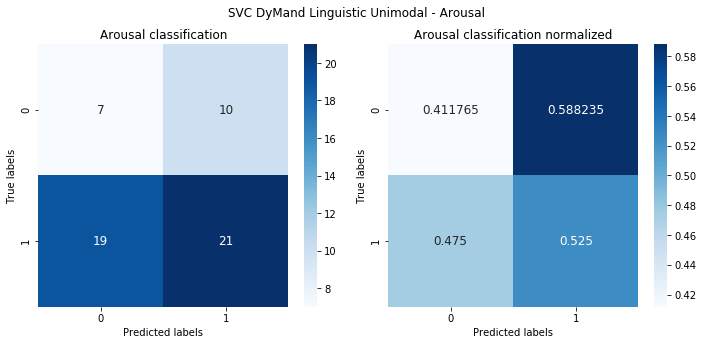

SVM validation Arousal score with best hyperparameters - Lexical Model: 0.46838235294117647


In [302]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_arousal_x
y_train = lexical_arousal_y
X_test = lexical_arousal_x_val
y_test = lexical_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight="balanced", degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Linguistic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Lexical Model:", uar)

In [230]:
# Creating a train and test set for hyperparameter tuning

# Giving the same training and validation groups as in early fusion for arousal
train_idxs = lexical_unimodal_labels_merge_arousal.loc[lexical_unimodal_labels_merge_arousal['ID'].isin(['003', '004', '005', '009', '012', '013'])].index.to_list()
test_idxs = lexical_unimodal_labels_merge_arousal.loc[lexical_unimodal_labels_merge_arousal['ID'].isin(["007", "008"])].index

lexical_arousal_x_train = lexical_arousal_x_all.loc[train_idxs]
lexical_arousal_y_train = lexical_arousal_y_all.loc[train_idxs]
lexical_arousal_x_test = lexical_arousal_x_all.loc[test_idxs]
lexical_arousal_y_test = lexical_arousal_y_all.loc[test_idxs]

lexical_arousal_x_train_groups = np.unique(lexical_train_test_groups_arousal.loc[train_idxs])
lexical_arousal_x_test_groups = np.unique(lexical_train_test_groups_arousal.loc[test_idxs])
        
print("Training groups: ", lexical_arousal_x_train_groups)
print("Testing groups: ", lexical_arousal_x_test_groups) # 7 and 9 would be better balanced

Training groups:  ['003' '004' '005' '009' '012' '013']
Testing groups:  ['007' '008']


In [167]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=768, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_AudioLexicalUnimodal',
                     project_name='Trial4_Lexical_Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(lexical_arousal_x_train, lexical_arousal_y_train, epochs=100, validation_data=(lexical_arousal_x_test, lexical_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 02s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.6076388955116272
Total elapsed time: 00h 02m 42s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 448 
 Second layer: 32 
 Third layer: 224 
 
 Dropout 1: 0.3 
 Dropout 2: 0.5 
 Dropout 3: 0.1 
 and the optimal learning rate for the optimizer
is 1e-05.



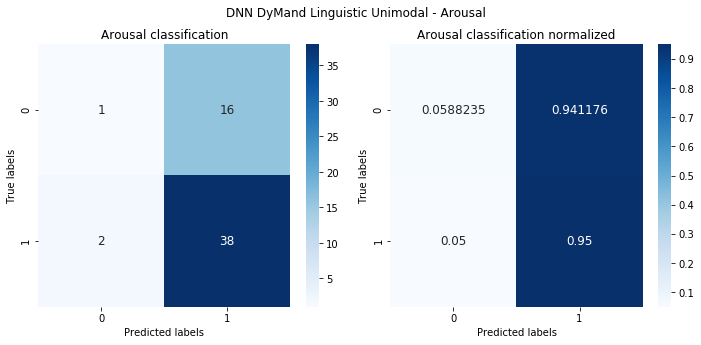

DNN validation score arousal with best hyperparameters -- Lexical Lexical 0.5044117647058823


In [303]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_arousal_x
y_train = lexical_arousal_y
X_test = lexical_arousal_x_val
y_test = lexical_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(448, input_dim=768, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(224, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(240, input_dim=768, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(320, activation="relu"))
#     model.add(Dropout(0.0))
#     model.add(Dense(416, activation="relu"))
#     model.add(Dropout(0.4))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=1e-5)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Linguistic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Lexical Lexical", uar)
# print("DNN validation score arousal with best hyperparameters -- Lexical Model", np.mean(uar_average), np.std(uar_average))

### Late Fusion: Valence -- Lexical

In [ ]:
# # Splitting in X and y
# lexical_valence_x = lexical_unimodal_labels_merge_valence.drop(columns=(["Name","Valence_binary"]))
# lexical_valence_y = lexical_unimodal_labels_merge_valence["Valence_binary"]

In [232]:
lexical_valence_x_all = lexical_unimodal_labels_merge_valence.drop(columns=(["Name","Valence_binary","PID", "ID"]))
lexical_valence_y_all = lexical_unimodal_labels_merge_valence["Valence_binary"]

# Get stratified split to make validation set
cv = StratifiedGroupKFold(n_splits=5, random_state=29, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(lexical_valence_x_all, lexical_valence_y_all, lexical_valence_groups)):
    if folds == 1: 
        lexical_valence_x = lexical_valence_x_all.iloc[train_idxs]
        lexical_valence_y = lexical_valence_y_all.iloc[train_idxs]
        lexical_valence_x_val = lexical_valence_x_all.iloc[test_idxs]
        lexical_valence_y_val = lexical_valence_y_all.iloc[test_idxs]
        
        lexical_train_test_groups_valence = lexical_valence_groups.iloc[train_idxs]
        lexical_val_groups_valence = lexical_valence_groups.iloc[test_idxs]
        
        lexical_train_test_groups_valence_unique = np.unique(lexical_valence_groups.iloc[train_idxs])
        lexical_val_groups_valence_unique = np.unique(lexical_valence_groups.iloc[test_idxs])
        
print(lexical_valence_x.shape)
print(lexical_valence_x_val.shape)
print("Train test groups: ", lexical_train_test_groups_valence_unique)
print("Validation groups: ", lexical_val_groups_valence_unique)

(126, 768)
(60, 768)
Train test groups:  ['003' '006' '007' '008' '010' '012']
Validation groups:  ['004' '009']


In [ ]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=4, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(lexical_valence_x, lexical_valence_y, groups=lexical_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


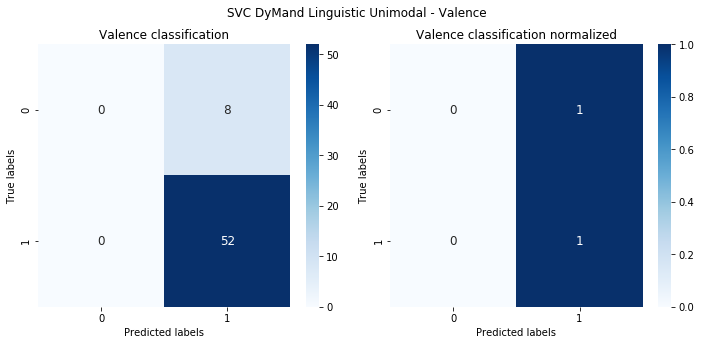

SVM validation score valence with best hyperparameters -- Lexical Unimodal: 0.5


In [304]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_valence_x
y_train = lexical_valence_y
X_test = lexical_valence_x_val
y_test = lexical_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1e-06,class_weight=None, degree=2, kernel="linear")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)
uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Linguistic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation score valence with best hyperparameters -- Lexical Unimodal:", uar)

In [234]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(lexical_valence_x, lexical_valence_y, lexical_train_test_groups_valence)):
    if folds == 1: 
        lexical_valence_x_train = lexical_valence_x_all.iloc[train_idxs]
        lexical_valence_y_train = lexical_valence_y_all.iloc[train_idxs]
        lexical_valence_x_test = lexical_valence_x_all.iloc[test_idxs]
        lexical_valence_y_test = lexical_valence_y_all.iloc[test_idxs]
        
        lexical_valence_x_train_groups = np.unique(lexical_train_test_groups_valence.iloc[train_idxs])
        lexical_valence_x_test_groups = np.unique(lexical_train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", lexical_valence_x_train_groups)
print("Testing groups: ", lexical_valence_x_test_groups)

Training groups:  ['003' '006' '007' '008' '012']
Testing groups:  ['010']


In [210]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=768, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_AudioLexicalUnimodal',
                     project_name='Trial3_Lexical_Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(lexical_valence_x_train, lexical_valence_y_train, epochs=100, validation_data=(lexical_valence_x_test, lexical_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.7333333492279053
Total elapsed time: 00h 02m 11s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 160 
 Second layer: 96 
 Third layer: 256 
 
 Dropout 1: 0.0 
 Dropout 2: 0.2 
 Dropout 3: 0.0 
 and the optimal learning rate for the optimizer
is 1e-05.



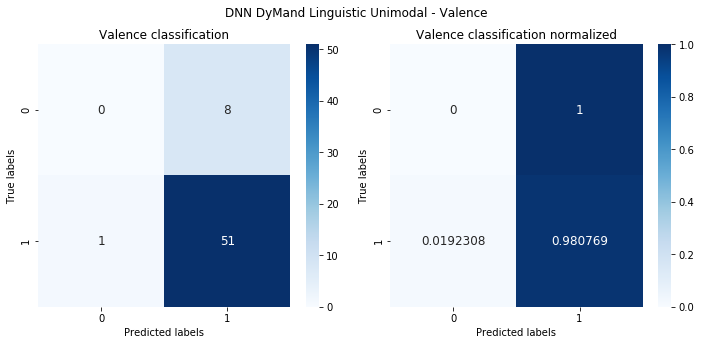

DNN validation score valence with best hyperparameters -- Lexical Model 0.49038461538461536


In [329]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_valence_x
y_train = lexical_valence_y
X_test = lexical_valence_x_val
y_test = lexical_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(160, input_dim=768, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(96, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(96, input_dim=768, activation="relu"))
#     model.add(Dropout(0.2))
#     model.add(Dense(192, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(304, activation="relu"))
#     model.add(Dropout(0.4))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=1e-05)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
# ############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Linguistic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score valence with best hyperparameters -- Lexical Model", uar)
# print("DNN validation score valence with best hyperparameters -- Lexical Model", np.mean(uar_average), np.std(uar_average))

## Late fusion (Audio and Lexical) - Arousal

Late fusion averaging 0.5676470588235294
Late fusion averaging prediction after converting predictions to binary 0.6183823529411765
Late fusion max of either input 0.5
Late fusion median 0.5676470588235294


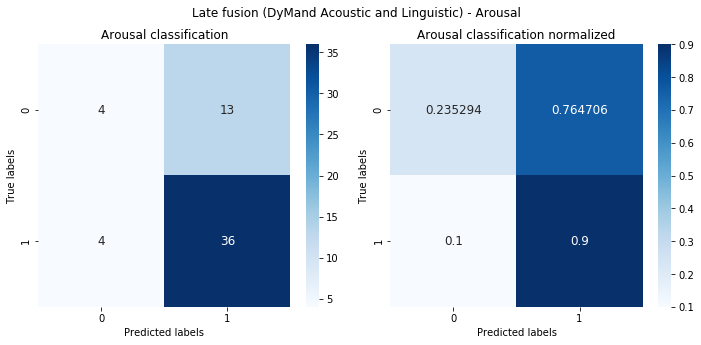

In [337]:
# Late fusion using averaging of predictions

# Find true values of arousal in validation set [001, 006, 010] that is common for both

if (audio_arousal_y_val.equals(lexical_arousal_y_val)):
    audio_lexical_y_val = lexical_arousal_y_val # Should be the same as audio
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler audio
scaler_audio = StandardScaler()
audio_arousal_x_scaled = scaler_audio.fit_transform(audio_arousal_x) # train
audio_arousal_x_val_scaled = scaler_audio.transform(audio_arousal_x_val) #test 

# Best DNN for audio arousal
audio_unimodal_arousal = Sequential()
audio_unimodal_arousal.add(Dense(160, input_dim=88, activation="relu"))
audio_unimodal_arousal.add(Dropout(0.3))
audio_unimodal_arousal.add(Dense(80, activation="relu"))
audio_unimodal_arousal.add(Dropout(0.0))
audio_unimodal_arousal.add(Dense(400, activation="relu"))
audio_unimodal_arousal.add(Dropout(0.2))
audio_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
audio_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
audio_unimodal_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
# Prediction
audio_unimodal_arousal_y_pred = audio_unimodal_arousal.predict(audio_arousal_x_val_scaled, verbose=0)

# Best DNN for lexical arousal

# StandardScaler lexical
scaler_lexical = StandardScaler()
lexical_arousal_x_scaled = scaler.fit_transform(lexical_arousal_x) # train
lexical_arousal_x_val_scaled = scaler.transform(lexical_arousal_x_val) #test 

lexical_unimodal_arousal = Sequential()
lexical_unimodal_arousal.add(Dense(448, input_dim=768, activation="relu"))
lexical_unimodal_arousal.add(Dropout(0.3))
lexical_unimodal_arousal.add(Dense(32, activation="relu"))
lexical_unimodal_arousal.add(Dropout(0.5))
lexical_unimodal_arousal.add(Dense(224, activation="relu"))
lexical_unimodal_arousal.add(Dropout(0.1))
lexical_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-5)
lexical_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
lexical_unimodal_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
# Prediction
lexical_unimodal_arousal_y_pred = lexical_unimodal_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)

# Evaluate on 
audio_lexical_pred_merge_arousal = np.array([audio_unimodal_arousal_y_pred,lexical_unimodal_arousal_y_pred])

# Averaging prediction (baseline)
late_fusion_audio_lexical_pred_avg = np.rint(audio_lexical_pred_merge_arousal.mean(axis=0))
uar_late_fusion_audio_lexical_pred_avg = balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_avg)
print("Late fusion averaging", uar_late_fusion_audio_lexical_pred_avg)

# Averaging prediction after converting predictions (baseline)
audio_lexical_pred_merge_arousal_binary = np.array([np.rint(audio_unimodal_arousal_y_pred),np.rint(lexical_unimodal_arousal_y_pred)])
late_fusion_audio_lexical_pred_avg_binary = np.rint(audio_lexical_pred_merge_arousal_binary.mean(axis=0))
uar_late_fusion_audio_lexical_pred_binary= balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_audio_lexical_pred_binary)

# Taking max prediction
late_fusion_audio_lexical_pred_max = np.rint(audio_lexical_pred_merge_arousal.max(axis=0))
uar_late_fusion_audio_lexical_pred_max = balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_max)
print("Late fusion max of either input", uar_late_fusion_audio_lexical_pred_max)

# Taking median
late_fusion_audio_lexical_pred_median = np.rint(np.median(audio_lexical_pred_merge_arousal, axis=0))
uar_late_fusion_audio_lexical_pred_median = balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_median)
print("Late fusion median", uar_late_fusion_audio_lexical_pred_median)

cm = confusion_matrix(audio_arousal_y_val,late_fusion_audio_lexical_pred_avg)
cm_normalized = confusion_matrix(audio_arousal_y_val,late_fusion_audio_lexical_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (DyMand Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [322]:
####### Transfer learning ########

# StandardScaler audio
scaler_audio = StandardScaler()
audio_arousal_x_scaled = scaler_audio.fit_transform(audio_arousal_x) # train
audio_arousal_x_val_scaled = scaler_audio.transform(audio_arousal_x_val) #test 

## Transfer learning audio 
print("Transfer learning audio arousal unimodal")

audio_TL_model_arousal = load_model("../VAM/VAM_audio_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.001

#Freezing no layers
# for i in range(7):
#     audio_TL_model_arousal.layers[i].trainable = True


# audio_TL_model_arousal.summary()
audio_TL_model_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_arousal.predict(audio_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_arousal_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
audio_TL_model_arousal = load_model("../VAM/VAM_audio_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    audio_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_arousal.summary()
audio_TL_model_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_arousal.predict(audio_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_arousal_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
audio_TL_model_arousal = load_model("../VAM/VAM_audio_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    audio_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_arousal.summary()
audio_TL_model_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_arousal.predict(audio_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_arousal_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
audio_TL_model_arousal = load_model("../VAM/VAM_audio_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    audio_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_arousal.summary()
audio_TL_model_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_arousal.predict(audio_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_arousal_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
audio_TL_model_arousal = load_model("../VAM/VAM_audio_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    audio_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_arousal.summary()
audio_TL_model_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_arousal.predict(audio_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_arousal_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

print()

# Transfer learning lexical 

# StandardScaler lexical
scaler_lexical = StandardScaler()
lexical_arousal_x_scaled = scaler_lexical.fit_transform(lexical_arousal_x) # train
lexical_arousal_x_val_scaled = scaler_lexical.transform(lexical_arousal_x_val) #test 

## Transfer learning lexical 
print("Transfer learning lexical arousal unimodal")

lexical_TL_model_arousal = load_model("../VAM/VAM_lexical_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.001

#Freezing no layers
# for i in range(7):
#     lexical_TL_model_arousal.layers[i].trainable = True


# lexical_TL_model_arousal.summary()
lexical_TL_model_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_arousal_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
lexical_TL_model_arousal = load_model("../VAM/VAM_lexical_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    lexical_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_arousal.summary()
lexical_TL_model_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_arousal_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
lexical_TL_model_arousal = load_model("../VAM/VAM_lexical_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    lexical_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_arousal.summary()
lexical_TL_model_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_arousal_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
lexical_TL_model_arousal = load_model("../VAM/VAM_lexical_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    lexical_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_arousal.summary()
lexical_TL_model_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_arousal_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
lexical_TL_model_arousal = load_model("../VAM/VAM_lexical_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    lexical_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_arousal.summary()
lexical_TL_model_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_arousal_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

Transfer learning audio arousal unimodal
Transfer learning after freezing 0 layers 0.5007352941176471
Transfer learning after freezing 1 layer 0.4838235294117647
Transfer learning after freezing 2 layers 0.5676470588235294
Transfer learning after freezing 3 layers 0.4875
Transfer learning after freezing 4 layers 0.40955882352941175

Transfer learning lexical arousal unimodal
Transfer learning after freezing 0 layers 0.5183823529411764
Transfer learning after freezing 1 layer 0.6264705882352941
Transfer learning after freezing 2 layers 0.5801470588235295
Transfer learning after freezing 3 layers 0.5507352941176471
Transfer learning after freezing 4 layers 0.5352941176470588


Late fusion averaging arousal 0.6772058823529412


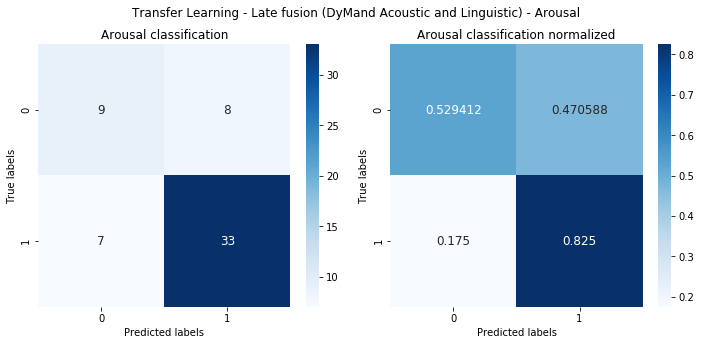

In [323]:
# Finding best results and use those for predictions

# Getting best results from audio arousal unimodal 

# Freezing layers first 2 layers (including dropout)
audio_TL_model_arousal = load_model("../VAM/VAM_audio_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    audio_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_arousal.summary()
audio_TL_model_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
# Prediction
audio_TL_unimodal_arousal_y_pred = audio_TL_model_arousal.predict(audio_arousal_x_val_scaled, verbose=0)
audio_TL_unimodal_arousal_y_pred = np.rint(audio_TL_unimodal_arousal_y_pred)


#####
# Freezing layers first layer (including dropout)
lexical_TL_model_arousal = load_model("../VAM/VAM_lexical_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    lexical_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_arousal.summary()
lexical_TL_model_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
# Prediction
lexical_TL_unimodal_arousal_y_pred = lexical_TL_model_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)
lexical_TL_unimodal_arousal_y_pred = np.rint(lexical_TL_unimodal_arousal_y_pred)

# Evaluate on 
audio_lexical_pred_merge_arousal = np.array([audio_TL_unimodal_arousal_y_pred,lexical_TL_unimodal_arousal_y_pred])

# Averaging prediction (baseline)
late_fusion_TL_audio_lexical_pred_avg = np.rint(audio_lexical_pred_merge_arousal.mean(axis=0))
uar_late_fusion_TL_audio_lexical_pred_avg = balanced_accuracy_score(audio_arousal_y_val, late_fusion_TL_audio_lexical_pred_avg)
print("Late fusion averaging arousal", uar_late_fusion_TL_audio_lexical_pred_avg)

# Plotting the confusion matrix
cm = confusion_matrix(audio_arousal_y_val,late_fusion_TL_audio_lexical_pred_avg)
cm_normalized = confusion_matrix(audio_arousal_y_val,late_fusion_TL_audio_lexical_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Late fusion (DyMand Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Late fusion Audio Lexical Arousal using DNN


In [134]:
# # Late fusion using DNN

# # Find true values of arousal in validation set [001, 006, 010] that is common for both

# if (audio_arousal_y_val.equals(lexical_arousal_y_val)):
#     audio_lexical_y_val = lexical_arousal_y_val # Should be the same as audio
# else:
#     raise("labels are not same")
    
# # Get best DNN models and average predictions

# # StandardScaler audio
# scaler_audio = StandardScaler()
# audio_arousal_x_scaled = scaler_audio.fit_transform(audio_arousal_x) # train
# audio_arousal_x_val_scaled = scaler_audio.transform(audio_arousal_x_val) #test 

# # Best DNN for audio arousal
# audio_unimodal_arousal = Sequential()
# audio_unimodal_arousal.add(Dense(496, input_dim=88, activation="relu"))
# audio_unimodal_arousal.add(Dropout(0.1))
# audio_unimodal_arousal.add(Dense(336, activation="relu"))
# audio_unimodal_arousal.add(Dropout(0.1))
# audio_unimodal_arousal.add(Dense(224, activation="relu"))
# audio_unimodal_arousal.add(Dropout(0.2))
# #audio_unimodal_arousal.add(Dense(1, activation="sigmoid"))

# # Best DNN for lexical arousal

# # StandardScaler lexical
# scaler_lexical = StandardScaler()
# lexical_arousal_x_scaled = scaler.fit_transform(lexical_arousal_x) # train
# lexical_arousal_x_val_scaled = scaler.transform(lexical_arousal_x_val) #test 

# lexical_unimodal_arousal = Sequential()
# lexical_unimodal_arousal.add(Dense(240, input_dim=768, activation="relu"))
# lexical_unimodal_arousal.add(Dropout(0.5))
# lexical_unimodal_arousal.add(Dense(320, activation="relu"))
# lexical_unimodal_arousal.add(Dropout(0.0))
# lexical_unimodal_arousal.add(Dense(416, activation="relu"))
# lexical_unimodal_arousal.add(Dropout(0.4))
# #lexical_unimodal_arousal.add(Dense(1, activation="sigmoid"))


# # Evaluate on 

In [136]:
# # Creating the audio and lexical late fusion model using the unimodal architecture

# # Defining the input layer of the merged model in functional API
# mergedAudioLexical_arousal = keras.layers.Concatenate()([audio_unimodal_arousal.output, lexical_unimodal_arousal.output])
# # Output layer
# mergedAudioLexical_arousal = Dense(1, activation='sigmoid')(mergedAudioLexical_arousal)

# # Creating the model
# latefusion_AudioLexical_arousal_model = keras.Model([audio_unimodal_arousal.input, lexical_unimodal_arousal.input], mergedAudioLexical_arousal)
# opt = keras.optimizers.Adam(learning_rate=0.01)
# latefusion_AudioLexical_arousal_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# # Fitting the model
# stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=20)
# latefusion_AudioLexical_arousal_model.fit([audio_arousal_x, lexical_arousal_x], [audio_arousal_y, lexical_arousal_y], epochs = 100, verbose=0, callbacks=[stop_early])

# # Prediction
# latefusion_AudioLexical_arousal_y_pred = latefusion_AudioLexical_arousal_model.predict([audio_arousal_x_val, lexical_arousal_x_val], verbose=0)
# latefusion_AudioLexical_arousal_y_pred = np.rint(latefusion_AudioLexical_arousal_y_pred)
# latefusion_AudioLexical_arousal_y_pred
# uar_latefusion_AudioLexical_arousal_y_pred_model = balanced_accuracy_score(audio_arousal_y_val, latefusion_AudioLexical_arousal_y_pred)
# print(uar_latefusion_AudioLexical_arousal_y_pred_model)

# # latefusion_AudioLexical_arousal_model.summary()
# # keras.utils.plot_model(
# #     latefusion_AudioLexical_arousal_model,
# #     show_shapes=True,
# #     show_dtype=False,
# #     show_layer_names=True,
# #     rankdir="TB",
# #     expand_nested=False,
# #     dpi=96,
# #     layer_range=None,
# #     show_layer_activations=False,
# # )

0.5522875816993464


## Late Fusion (Audio and Lexical) - Valence

Late fusion averaging 0.5
Late fusion averaging prediction after converting predictions to binary 0.5
Late fusion max of either input 0.5
Late fusion median 0.5


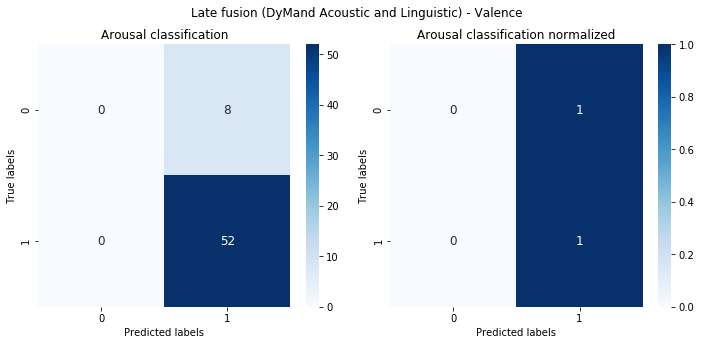

In [332]:
# Late fusion using averaging of predictions

# Find true values of valence in validation set [001, 006, 010] that is common for both

if (audio_valence_y_val.reset_index(drop=True).equals(lexical_valence_y_val.reset_index(drop=True))):
    audio_lexical_y_val = lexical_valence_y_val # Should be the same as audio
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler audio
scaler_audio = StandardScaler()
audio_valence_x_scaled = scaler_audio.fit_transform(audio_valence_x) # train
audio_valence_x_val_scaled = scaler_audio.transform(audio_valence_x_val) #test 

# Best DNN for audio valence
audio_unimodal_valence = Sequential()
audio_unimodal_valence.add(Dense(128, input_dim=88, activation="relu"))
audio_unimodal_valence.add(Dropout(0.2))
audio_unimodal_valence.add(Dense(304, activation="relu"))
audio_unimodal_valence.add(Dropout(0.1))
audio_unimodal_valence.add(Dense(240, activation="relu"))
audio_unimodal_valence.add(Dropout(0.5))
audio_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
audio_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
audio_unimodal_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
# Prediction
audio_unimodal_valence_y_pred = audio_unimodal_valence.predict(audio_valence_x_val_scaled, verbose=0)

# Best DNN for lexical valence

# StandardScaler lexical
scaler_lexical = StandardScaler()
lexical_valence_x_scaled = scaler_lexical.fit_transform(lexical_valence_x) # train
lexical_valence_x_val_scaled = scaler_lexical.transform(lexical_valence_x_val) #test 

lexical_unimodal_valence = Sequential()
lexical_unimodal_valence.add(Dense(160, input_dim=768, activation="relu"))
lexical_unimodal_valence.add(Dropout(0.0))
lexical_unimodal_valence.add(Dense(96, activation="relu"))
lexical_unimodal_valence.add(Dropout(0.2))
lexical_unimodal_valence.add(Dense(256, activation="relu"))
lexical_unimodal_valence.add(Dropout(0.0))
lexical_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
lexical_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
lexical_unimodal_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
# Prediction
lexical_unimodal_valence_y_pred = lexical_unimodal_valence.predict(lexical_valence_x_val_scaled, verbose=0)

# Evaluate on 
audio_lexical_pred_merge_valence = np.array([audio_unimodal_valence_y_pred,lexical_unimodal_valence_y_pred])

# Averaging prediction (baseline)
late_fusion_audio_lexical_pred_avg = np.rint(audio_lexical_pred_merge_valence.mean(axis=0))
uar_late_fusion_audio_lexical_pred_avg = balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_avg)
print("Late fusion averaging", uar_late_fusion_audio_lexical_pred_avg)

# Averaging prediction after converting predictions (baseline)
audio_lexical_pred_merge_valence_binary = np.array([np.rint(audio_unimodal_valence_y_pred),np.rint(lexical_unimodal_valence_y_pred)])
late_fusion_audio_lexical_pred_avg_binary = np.rint(audio_lexical_pred_merge_valence_binary.mean(axis=0))
uar_late_fusion_audio_lexical_pred_binary= balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_audio_lexical_pred_binary)

# Taking max prediction
late_fusion_audio_lexical_pred_max = np.rint(audio_lexical_pred_merge_valence.max(axis=0))
uar_late_fusion_audio_lexical_pred_max = balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_max)
print("Late fusion max of either input", uar_late_fusion_audio_lexical_pred_max)

# Taking median
late_fusion_audio_lexical_pred_median = np.rint(np.median(audio_lexical_pred_merge_valence, axis=0))
uar_late_fusion_audio_lexical_pred_median = balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_median)
print("Late fusion median", uar_late_fusion_audio_lexical_pred_median)

cm = confusion_matrix(audio_valence_y_val,late_fusion_audio_lexical_pred_avg)
cm_normalized = confusion_matrix(audio_valence_y_val,late_fusion_audio_lexical_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (DyMand Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [261]:
####### Transfer learning ########

# StandardScaler audio
scaler_audio = StandardScaler()
audio_valence_x_scaled = scaler_audio.fit_transform(audio_valence_x) # train
audio_valence_x_val_scaled = scaler_audio.transform(audio_valence_x_val) #test 

## Transfer learning audio 
print("Transfer learning audio valence unimodal")

audio_TL_model_valence = load_model("../VAM/VAM_audio_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.01

#Freezing no layers
# for i in range(7):
#     audio_TL_model_valence.layers[i].trainable = True


# audio_TL_model_valence.summary()
audio_TL_model_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_valence.predict(audio_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_valence_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
audio_TL_model_valence = load_model("../VAM/VAM_audio_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    audio_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_valence.summary()
audio_TL_model_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_valence.predict(audio_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_valence_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
audio_TL_model_valence = load_model("../VAM/VAM_audio_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    audio_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_valence.summary()
audio_TL_model_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_valence.predict(audio_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_valence_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
audio_TL_model_valence = load_model("../VAM/VAM_audio_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    audio_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_valence.summary()
audio_TL_model_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_valence.predict(audio_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_valence_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
audio_TL_model_valence = load_model("../VAM/VAM_audio_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    audio_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
audio_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# audio_TL_model_valence.summary()
audio_TL_model_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = audio_TL_model_valence.predict(audio_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(audio_valence_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

print()

# Transfer learning lexical 

# StandardScaler lexical
scaler_lexical = StandardScaler()
lexical_valence_x_scaled = scaler_lexical.fit_transform(lexical_valence_x) # train
lexical_valence_x_val_scaled = scaler_lexical.transform(lexical_valence_x_val) #test 

## Transfer learning lexical 
print("Transfer learning lexical valence unimodal")

lexical_TL_model_valence = load_model("../VAM/VAM_lexical_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.01

#Freezing no layers
# for i in range(7):
#     lexical_TL_model_valence.layers[i].trainable = True


# lexical_TL_model_valence.summary()
lexical_TL_model_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_valence.predict(lexical_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_valence_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
lexical_TL_model_valence = load_model("../VAM/VAM_lexical_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    lexical_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_valence.summary()
lexical_TL_model_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_valence.predict(lexical_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_valence_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
lexical_TL_model_valence = load_model("../VAM/VAM_lexical_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    lexical_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_valence.summary()
lexical_TL_model_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_valence.predict(lexical_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_valence_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
lexical_TL_model_valence = load_model("../VAM/VAM_lexical_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    lexical_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_valence.summary()
lexical_TL_model_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_valence.predict(lexical_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_valence_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
lexical_TL_model_valence = load_model("../VAM/VAM_lexical_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    lexical_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
lexical_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# lexical_TL_model_valence.summary()
lexical_TL_model_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = lexical_TL_model_valence.predict(lexical_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(lexical_valence_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

Transfer learning audio valence unimodal
Transfer learning after freezing 0 layers 0.5
Transfer learning after freezing 1 layer 0.5
Transfer learning after freezing 2 layers 0.5
Transfer learning after freezing 3 layers 0.5
Transfer learning after freezing 4 layers 0.3173076923076923

Transfer learning lexical valence unimodal
Transfer learning after freezing 0 layers 0.5
Transfer learning after freezing 1 layer 0.5
Transfer learning after freezing 2 layers 0.5
Transfer learning after freezing 3 layers 0.5
Transfer learning after freezing 4 layers 0.39903846153846156


Late fusion averaging valence 0.5432692307692307


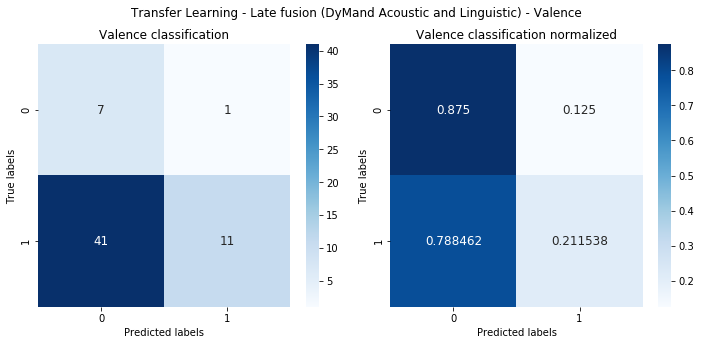

In [342]:
# Finding best results and use those for predictions

# Getting best results from audio valence unimodal 

# Freezing layers first 2 layers (including dropout)
audio_TL_model_valence = load_model("../VAM/VAM_audio_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    audio_TL_model_valence.layers[i].trainable = False

audio_TL_model_valence.compile(loss='binary_crossentropy',  metrics=[UAR_metric])
# audio_TL_model_valence.summary()
audio_TL_model_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
# Prediction
audio_TL_unimodal_valence_y_pred = audio_TL_model_valence.predict(audio_valence_x_val_scaled, verbose=0)
audio_TL_unimodal_valence_y_pred = np.rint(audio_TL_unimodal_valence_y_pred)


#####
# Freezing layers first 2 layers (including dropout)
lexical_TL_model_valence = load_model("../VAM/VAM_lexical_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    lexical_TL_model_valence.layers[i].trainable = False

lexical_TL_model_valence.compile(loss='binary_crossentropy', metrics=[UAR_metric])
# lexical_TL_model_valence.summary()
lexical_TL_model_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
# Prediction
lexical_TL_unimodal_valence_y_pred = lexical_TL_model_valence.predict(lexical_valence_x_val_scaled, verbose=0)
lexical_TL_unimodal_valence_y_pred = np.rint(lexical_TL_unimodal_valence_y_pred)

# Evaluate on 
audio_lexical_pred_merge_valence = np.array([audio_TL_unimodal_valence_y_pred,lexical_TL_unimodal_valence_y_pred])

# Averaging prediction (baseline)
late_fusion_TL_audio_lexical_pred_avg = np.rint(audio_lexical_pred_merge_valence.mean(axis=0))
uar_late_fusion_TL_audio_lexical_pred_avg = balanced_accuracy_score(audio_valence_y_val, late_fusion_TL_audio_lexical_pred_avg)
print("Late fusion averaging valence", uar_late_fusion_TL_audio_lexical_pred_avg)

# Plotting the confusion matrix
cm = confusion_matrix(audio_valence_y_val,late_fusion_TL_audio_lexical_pred_avg)
cm_normalized = confusion_matrix(audio_valence_y_val,late_fusion_TL_audio_lexical_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Late fusion (DyMand Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### Late fusion using DNN

In [139]:
# # Late fusion using DNN

# # Find true values of valence in validation set [001, 006, 010] that is common for both

# if (audio_valence_y_val.equals(lexical_valence_y_val)):
#     audio_lexical_y_val = lexical_valence_y_val # Should be the same as audio
# else:
#     raise("labels are not same")
    
# # Get best DNN models and average predictions

# # StandardScaler audio
# scaler_audio = StandardScaler()
# audio_valence_x_scaled = scaler.fit_transform(audio_valence_x) # train
# audio_valence_x_val_scaled = scaler.transform(audio_valence_x_val) #test 

# # Best DNN for audio valence
# audio_unimodal_valence = Sequential()
# audio_unimodal_valence.add(Dense(464, input_dim=88, activation="relu"))
# audio_unimodal_valence.add(Dropout(0.5))
# audio_unimodal_valence.add(Dense(304, activation="relu"))
# audio_unimodal_valence.add(Dropout(0.1))
# audio_unimodal_valence.add(Dense(32, activation="relu"))
# audio_unimodal_valence.add(Dropout(0.0))

# # Best DNN for lexical valence

# # StandardScaler lexical
# scaler_lexical = StandardScaler()
# lexical_valence_x_scaled = scaler.fit_transform(lexical_valence_x) # train
# lexical_valence_x_val_scaled = scaler.transform(lexical_valence_x_val) #test 

# lexical_unimodal_valence = Sequential()
# lexical_unimodal_valence.add(Dense(96, input_dim=768, activation="relu"))
# lexical_unimodal_valence.add(Dropout(0.2))
# lexical_unimodal_valence.add(Dense(192, activation="relu"))
# lexical_unimodal_valence.add(Dropout(0.5))
# lexical_unimodal_valence.add(Dense(304, activation="relu"))
# lexical_unimodal_valence.add(Dropout(0.4))

# # Evaluate on 

In [263]:
# # Creating the audio and lexical late fusion model using the unimodal architecture

# # Defining the input layer of the merged model in functional API
# mergedAudioLexical_valence = keras.layers.Concatenate()([audio_unimodal_valence.output, lexical_unimodal_valence.output])
# # Output layer
# mergedAudioLexical_valence = Dense(1, activation='sigmoid')(mergedAudioLexical_valence)

# # Creating the model
# latefusion_AudioLexical_valence_model = keras.Model([audio_unimodal_valence.input, lexical_unimodal_valence.input], mergedAudioLexical_valence)
# opt = keras.optimizers.Adam(learning_rate=0.01)
# latefusion_AudioLexical_valence_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# # Fitting the model
# stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=20)
# latefusion_AudioLexical_valence_model.fit([audio_valence_x, lexical_valence_x], [audio_valence_y, lexical_valence_y], epochs = 100, verbose=0, callbacks=[stop_early])

# # Prediction
# latefusion_AudioLexical_valence_y_pred = latefusion_AudioLexical_valence_model.predict([audio_valence_x_val, lexical_valence_x_val], verbose=0)
# latefusion_AudioLexical_valence_y_pred = np.rint(latefusion_AudioLexical_valence_y_pred)
# latefusion_AudioLexical_valence_y_pred
# uar_latefusion_AudioLexical_valence_y_pred_model = balanced_accuracy_score(audio_valence_y_val, latefusion_AudioLexical_valence_y_pred)
# print(uar_latefusion_AudioLexical_valence_y_pred_model)

# # latefusion_AudioLexical_valence_model.summary()
# # keras.utils.plot_model(
# #     latefusion_AudioLexical_valence_model,
# #     show_shapes=True,
# #     show_dtype=False,
# #     show_layer_names=True,
# #     rankdir="TB",
# #     expand_nested=False,
# #     dpi=96,
# #     layer_range=None,
# #     show_layer_activations=False,
# # )